In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

from utils.translation_utils import *
from utils.decomposition_utils import *

warnings.filterwarnings('ignore')

# Physics-inspired closed loop dynamics

In [12]:
from utils.translation_utils import *
from utils.decomposition_utils import *
from itertools import combinations, product

def combine_attrs(x1, x2):
    combined_attrs = {}
    for key in x1.attrs:
        combined_attrs[key] = x1.attrs[key]
    for key in x2.attrs:
        if key in combined_attrs:
            combined_attrs[key] += x2.attrs[key]
        else:
            combined_attrs[key] = x2.attrs[key]
    return combined_attrs

def symmetric_tensor_couple(data, keys=['m_ij', 'E']):
    '''
    Generate the three symmetric tensor couplings of two tensor fields
    A Tr(B), B Tr(A), and {A.B + B.A}
    '''
    raw = data['X_raw']
    for key1, key2 in combinations(keys, 2):
        x1 = raw[key1]
        x2 = raw[key2]

        combined_attrs = combine_attrs(x1, x2)

        feat = '%s Tr(%s)' % (key1, key2)
        if feat not in raw:
            raw[feat] = np.einsum('bijyx,bkkyx->bijyx', x1, x2)

        raw[feat].attrs.update(combined_attrs)

        feat = '%s Tr(%s)' % (key2, key1)
        if feat not in raw:
            raw[feat] = np.einsum('bijyx,bkkyx->bijyx', x2, x1)
        raw[feat].attrs.update(combined_attrs)

        feat = '{%s, %s}' % (key1, key2)
        if feat not in raw:
            y = np.einsum('bikyx,bkjyx->bijyx', x1, x2) + np.einsum('bikyx,bkjyx->bijyx', x2, x1)
            raw[feat] = y
        raw[feat].attrs.update(combined_attrs)

def add_static_sources(data, couple='m_ij'):
    '''
    Add a static DV and AP source to the library
    '''
    raw = data['X_raw']
    if not couple in raw:
        raise ValueError('%s not in X_raw' % like)
    
    x = np.zeros_like(raw[couple])
    x[:, 0, 0, :, :] = 1
    if not 'Static_DV' in raw:
        raw['Static_DV'] = x
    raw['Static_DV'].attrs.update({'space': 0})
    symmetric_tensor_couple(data, [couple, 'Static_DV'])
    del raw['%s Tr(%s)' % (couple, 'Static_DV')]
    
    '''
    x = np.zeros_like(raw[couple])
    x[:, 1, 1, :, :] = 1
    if not 'Static_AP' in raw:
        raw['Static_AP'] = x
    raw['Static_AP'].attrs.update({'space': 0})
    symmetric_tensor_couple(data, [couple, 'Static_AP'])
    del raw['%s Tr(%s)' % (couple, 'Static_AP')]
    '''
    
def material_derivative_terms(data, keys=['c']):
    '''
    Add a material derivative term (v.grad) key 
    For tensor fields, also add the co-rotation [Omega.key - key.Omega]
    '''
    for key in keys:
        D1_x = data['links'][key]['D1 %s' % key]
        v = data['fields']['v']

        raw = data['X_raw']
        x = raw[key]
        E = raw['E']
        O = raw['O']

        feat = 'v dot grad %s' % key
        if feat not in raw:
            if len(x.shape) == 5:
                raw[feat] = np.einsum('bkyx,bijyxk->bijyx', v, D1_x)
            else:
                raw[feat] = np.einsum('bkyx,byxk->byx', v, D1_x)
        raw[feat].attrs.update({key: 1, 'v': 1, 'space': 1})

        #Co-rotation term
        #SINCE Omega is v_[i,j] and not D_[i v_j] put a minus sign
        if len(x.shape) == 5:
            feat = '[O, %s]' % key
            if feat not in raw:
                raw[feat] = -(np.einsum('bikyx,bkjyx->bijyx', O, x) - np.einsum('bikyx,bkjyx->bijyx', x, O))
            raw[feat].attrs.update({key: 1, 'v': 1, 'space': 1})

def remove_terms(data, max_space_order=1):
    raw = data['X_raw']
    for key in raw:
        if raw[key].attrs['space'] > max_space_order:
            del raw[key]
            
    if 'O' in raw:
        del raw['O']
        
    if 'vv' in raw:
        del raw['vv']
        
def active_strain_decomposition(data, key='m_ij'):
    raw = data['X_raw']
    E = raw['E']
    x = raw[key]
    
    deviatoric = x - 0.5 * np.einsum('bkkyx,ij->bijyx', x, np.eye(2))
    
    x_0 = np.linalg.norm(x, axis=(1, 2), keepdims=True).mean(axis=(3, 4), keepdims=True)
    dev_mag = np.linalg.norm(deviatoric, axis=(1, 2), keepdims=True)
        
    devE = np.einsum('bklyx,bklyx->byx', deviatoric, E)[:, None, None]
    
    E_active = E - np.sign(devE) * devE * deviatoric / dev_mag**2
    E_active = 0.5 * E_active * dev_mag / x_0
    
    E_passive = E - E_active
    
    attrs = dict(E.attrs)
    
    #Remove regular strain terms from library
    del raw['E']
    
    raw['E_active'] = E_active
    raw['E_active'].attrs.update(attrs)
    
    raw['E_passive'] = E_passive
    raw['E_passive'].attrs.update(attrs)
    
def scalar_tensor_couple(data, scalars, tensors):
    '''
    Order-1 couplings between a scalar and tensors
    Without adding gradients, the only thing we can really do is multiply scalar by the trace
    '''
    raw = data['X_raw']
    for key1, key2 in product(scalars, tensors):
        x1 = raw[key1]
        x2 = raw[key2]

        combined_attrs = combine_attrs(x1, x2)

        feat = '%s Tr(%s)' % (key1, key2)
        if feat not in raw:
            raw[feat] = np.einsum('byx,bkkyx->byx', x1, x2)
        raw[feat].attrs.update(combined_attrs)

def multiply_tensor_by_scalar(data, tensors, scalars):
    '''
    Order-1 couplings between scalars and tensors
    Without adding gradients, all we can do is multiply the two
    '''
    raw = data['X_raw']
    
    if tensors is None:
        tensors = []
        for key in raw:
            if len(raw[key].shape) == 5 and not 'O' in key:
                tensors.append(key)
    
    for key1, key2 in product(scalars, tensors):
        x1 = raw[key1]
        x2 = raw[key2]

        combined_attrs = combine_attrs(x1, x2)

        feat = '%s %s' % (key1, key2)
        if feat not in raw:
            raw[feat] = np.einsum('byx,bijyx->bijyx', x1, x2)
        raw[feat].attrs.update(combined_attrs)

    
def add_dorsal_sources(data, couple='c', key='RECTANGLE',
                       x_path='Public/dorsal_mask_',
                       t_path='Public/dorsal_mask_time.npy'):
    '''
    Add the time-aligned and advected dorsal source to this dataset
    '''
    raw = data['X_raw']
    if not couple in raw:
        raise ValueError('%s not in X_raw' % like)
    
    x = np.load(x_path+key+'_advected_RESIZED.npy', mmap_mode='r')
    t0 = np.load(t_path, mmap_mode='r')
    
    t = data['t']
    
    x = interp1d(t0, x, axis=0, fill_value='extrapolate', bounds_error=False)(t)
    raw['Dorsal_Source'] = x
    raw['Dorsal_Source'].attrs.update({'space': 0})
        
libraries = [
    ('c', 'Public/WT/ECad-GFP', 'scalar_library', 'cyt_SVDPipeline_PMG_CF.pkl'), 
    ('v', 'Public/WT/ECad-GFP', 'tensor_library', None), #Not focused on dynamics
    ('m_ij', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', 'tensor_SVDPipeline_PMG_CF.pkl'),
]

    
extra_functions = [
    lambda data: material_derivative_terms(data, keys=['m_ij', 'c']),
    lambda data: scalar_tensor_couple(data, ['c', 'c^2'], ['E', 'm_ij']),
    lambda data: active_strain_decomposition(data, key='m_ij'),
    lambda data: add_static_sources(data, couple='m_ij'),
    lambda data: add_dorsal_sources(data, couple='c', key='ELLIPSE_A=0.5_B=0.25'),
    lambda data: symmetric_tensor_couple(data, ['m_ij', 'E_active', 'E_passive']),
    lambda data: remove_terms(data, max_space_order=1),
    lambda data: multiply_tensor_by_scalar(data, None, ['c']),
]


embryoIDs = None
for key, path, _, _ in libraries:
    with h5py.File(os.path.join(path, 'derivative_library.h5'), 'r') as h5f:
        eIds = list(h5f.keys())
        if embryoIDs is None:
            embryoIDs = set(eIds)
        else:
            embryoIDs = embryoIDs.intersection(eIds)
embryoIDs = list(embryoIDs)
#embryoIDs = ['ensemble']
#embryoIDs = ['202001280915']
with h5py.File('Public/symmetric_dynamics_fitting.h5', 'w') as data:
    for embryoID in embryoIDs:
        print(embryoID)
        group, feature_names, control_names = fill_group_info(data, embryoID, libraries, [])
        collect_library(group, 
                        libraries, 
                        feature_names, 
                        extra_functions=extra_functions)
        decompose_library(group, libraries, window_length=7)
        print('DONE')

ensemble
Computing time derivatives
Computing time derivatives
DONE


Using only overleaf-allowed terms
Adding Material Derivative terms to LHS
Applying train/test split
D_t c  = 0.265 Dorsal_Source + -0.020 c + -0.472 c Tr(E)
PCA Component R2=-1.99029	MSE=0.268103


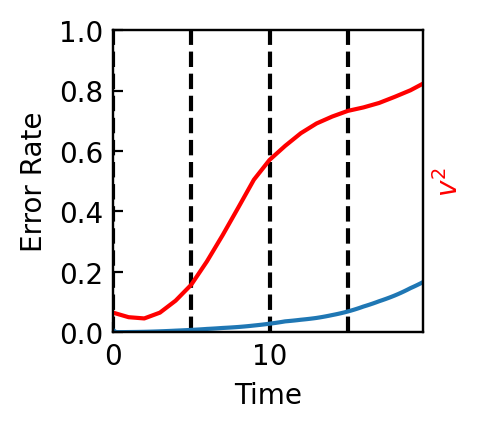

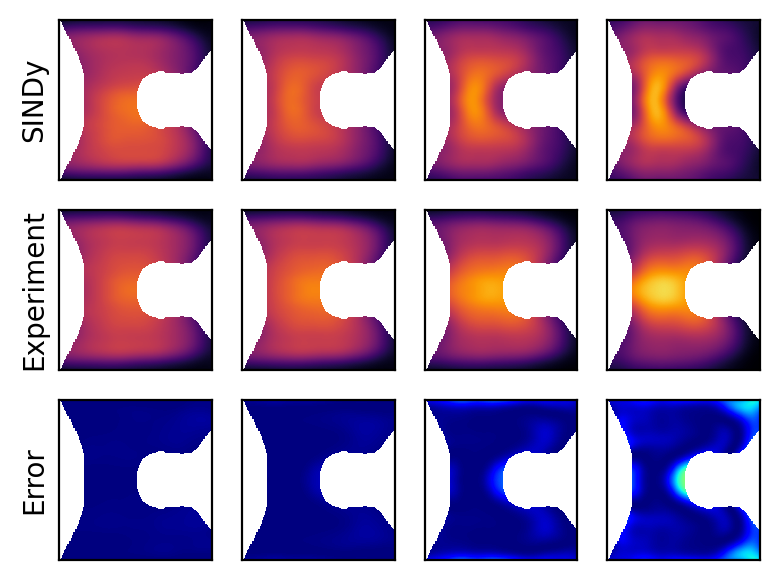

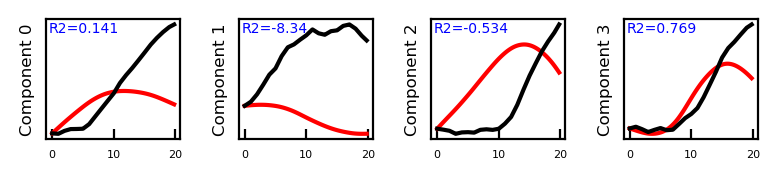

In [65]:
from utils.translation_utils import *

lib_path = 'data/WT/ECad-GFP'
lib_key = 'c'

plt.rcParams['figure.dpi'] = 200

with h5py.File('Public/symmetric_dynamics_fitting.h5', 'r') as h5f:
    model = pk.load(open(os.path.join(lib_path, 'decomposition_models', 'cyt_SVDPipeline_PMG_CF.pkl'), 'rb'))
    evr = model['svd'].explained_variance_ratio_
    keep=np.cumsum(evr) <= 0.93
    scaled_evr = evr / np.min(evr[keep]) * keep
    
    info = dict(
        key=lib_key,
        #tmin=1,
        #tmax=15,
        tmin=0, tmax=30,
        scale_units=True,
        material_derivative=True,
        keep=keep,
        component_weight=scaled_evr**2,
        threshold=1e-2,
        alpha=1e0,
        n_candidates_to_drop=0,
        n_models=5,
        overleaf_only=True,
    )
    sindy = fit_sindy_model(h5f, **info)


    data = h5f['ensemble']
    '''
    Evaluate model
    '''
    tmin, tmax = info['tmin'], info['tmax']
    tmin, tmax = 0, 20
    
    keep = np.cumsum(evr) <= 0.98
    tmin = max(tmin, int(np.min(data['t'])))
    tmax = min(tmax, int(np.max(data['t'])))
    pred, interp, times = sindy_predict(data, lib_key, sindy, model, keep, tmin=tmin, tmax=tmax)
    sindy_predictions_plot(pred, interp, model, times, keep, data, plot_fn=color_2D)
    decomposed_predictions_plot(pred, interp, model, times, info['keep'])

PCA Component R2=-0.348683	MSE=0.0208392


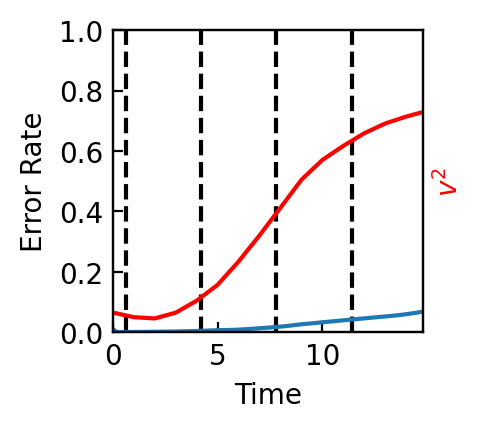

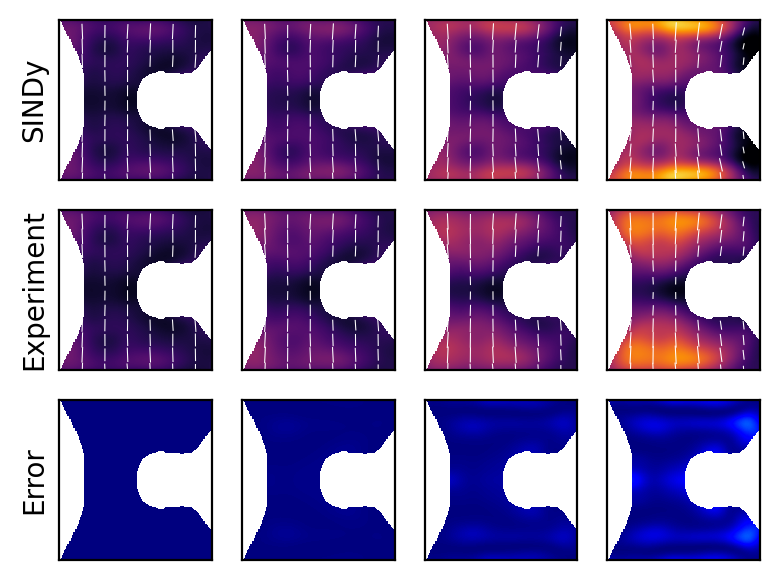

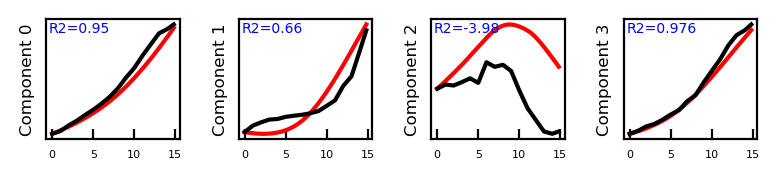

In [56]:
from utils.translation_utils import *

lib_path = 'data/WT/sqh-mCherry'
lib_key = 'm_ij'
plt.rcParams['figure.dpi'] = 200
np.set_printoptions(precision=3, suppress=True)

with h5py.File('Public/symmetric_dynamics_fitting.h5', 'r') as h5f:
    model = pk.load(open(os.path.join(lib_path, 'decomposition_models', 'tensor_SVDPipeline_PMG_CF.pkl'), 'rb'))
    evr = model['svd'].explained_variance_ratio_
    keep=np.cumsum(evr) <= 0.95
    scaled_evr = evr / np.min(evr[keep]) * keep
    
    info = dict(
        key=lib_key,
        tmin=0, tmax=15,
        scale_units=True,
        material_derivative=True,
        keep=keep,
        component_weight=scaled_evr**2,
        threshold=1e-2,
        alpha=1e0,
        n_candidates_to_drop=0,
        n_models=5,
        overleaf_only=True,
    )
    #sindy = fit_sindy_model(h5f, **info)

    data = h5f['ensemble']
    #data = h5f['202001280915']
    #data = h5f['202001282000']
    
    '''
    Evaluate model
    '''
    tmin, tmax = info['tmin'], info['tmax']
    
    keep = np.cumsum(evr) <= 0.98
    tmin = max(tmin, int(np.min(data['t'])))
    tmax = min(tmax, int(np.max(data['t'])))
    pred, interp, times = sindy_predict(data, lib_key, sindy, model, keep, tmin=tmin, tmax=tmax)
    sindy_predictions_plot(pred, interp, model, times, keep, data)
    decomposed_predictions_plot(pred, interp, model, times, info['keep'])

# Building ensembles of models

To evaluate which terms are more or less accurate to these models, we are going to back off the accuracy requirement a bit. Instead, we'll generate models at different sparsity thresholds and randomly leave terms out of the libraries. This way we can get an ensemble of nearly equivalent models with different accuracy scores.

At the same time, we'll make two modifications to the fitting procedure. First, we'll eliminate pair rule genes from the library, as we don't see them except at very low sparsity. Second, we will fit on a narrower range $t \in [25, 40]$ and test on $t \in [15, 45]$

In [ ]:
def collect_decomposed_data(h5f, key, tmin, tmax, keep, scale_units=False, material_derivative=True):
    ''' 
    Collect the PCA data froma  given h5f library and return X, U, X_dot, and the relevant variable names

    New: Include the option to rescale components by their units
        Each field has a characteristic unit and we include the option to unscale everything

        the returned scale_array is the unit factor we need to multiply by to get to units of key / time
        these are the units of the feature
        Each feature should be multiplied by these units, and its coefficient should be divided by them
    '''
    feature_names = list(h5f['X_cpt'][key].attrs['feature_names'])

    
    t_X = h5f['t'][()].astype(int)    
    t_mask = np.logical_and(t_X >= tmin, t_X <= tmax)
    times = t_X[t_mask]

    X = h5f['X_cpt'][key][t_mask, ...][..., keep, :][()]
    X_dot = h5f['X_dot_cpt'][key][t_mask, ...][..., keep, :][()]

    if material_derivative:
        adv = 'v dot grad %s' % key 
        if adv in feature_names:
            loc = feature_names.index(adv)
            X_dot += X[..., loc:loc+1]
            X = np.delete(X, loc, axis=-1)
            feature_names.remove(adv)

        cor = '[O, %s]' % key 
        if cor in feature_names:
            loc = feature_names.index(cor)
            X_dot -= X[..., loc:loc+1]
            X = np.delete(X, loc, axis=-1)
            feature_names.remove(cor)

    #Eliminate other advection terms because they involve gradients of proteins
    adv = [feature for feature in feature_names if 'v dot grad' in feature]
    for a in adv:
        loc = feature_names.index(a)
        X = np.delete(X, loc, axis=-1)
        feature_names.remove(a)

    scale_array = np.ones(X.shape[-1])
    if scale_units:
        fields = h5f['fields']
        base = fields[key].attrs['std']
        for i, feature in enumerate(feature_names):
            attrs = h5f['X_raw'][feature].attrs
            for unit in attrs:
                if unit in fields and not unit == 'v':
                    scale_array[i] /= (fields[unit].attrs['std'] / base) ** attrs[unit]

    return X, X_dot, times, feature_names, scale_array

from sklearn.model_selection import train_test_split
def fit_sindy_model(h5f, 
                    key,
                    keep,
                    tmin=25, 
                    tmax=40, 
                    threshold=1e-1, 
                    alpha=1e-1, 
                    n_models=10,
                    n_candidates_to_drop=5,
                    scale_units=False, 
                    material_derivative=False):
    '''
    Fit a SINDy model on data filled by a given key in an h5py file
    Fit range goes from tmin to tmax, and is applied on a set keep of PCA components

    New: Include the option to rescale components by their units
        Each field has a characteristic unit and we include the option to unscale everything
        In general, the goal should be to use v as a reference
    '''
    X, X_dot, scales = [], [], []
    eIds = list(h5f.keys())
    for eId in eIds:
        x, x_dot, times, feature_names, scale = collect_decomposed_data(
            h5f[eId],
            key,
            tmin,
            tmax,
            keep,
            scale_units,
            material_derivative)
        X.append(x * scale[:len(feature_names)])
        X_dot.append(x_dot)
        scales.append(scale)

    X_train, X_test, X_dot_train, X_dot_test = train_test_split(X, X_dot, test_size=0.33)
    scales = np.mean(scales, axis=0)
    
    optimizer = ps.EnsembleOptimizer(
        opt=ps.STLSQ(threshold=threshold, alpha=alpha),
        bagging=False,
        library_ensemble=True,
        n_models=n_models,
        n_candidates_to_drop=n_candidates_to_drop,
    )
        
    sindy = ps.SINDy(
        feature_library=ps.IdentityLibrary(),
        optimizer=optimizer,
        feature_names=feature_names,
    )
    sindy.fit(x=X_train, x_dot=X_dot_train, multiple_trajectories=True)

    if material_derivative:
        #sindy.print(lhs=['D_t %s ' % key])
        sindy.material_derivative_ = True
    else:
        #sindy.print(lhs=['d_t %s' % key])
        sindy.material_derivative_ = False
    sindy.model.steps[-1][1].optimizer.coef_[:] *= scales
    return sindy

D_t c = 0.161 Tr(E) Tr(c) c + -14.247 Tr(E) Tr(m) m + 7.127 Tr(c m) m + -1.607 Tr(c) {m, c} + 3.740 Tr(c^2) m + -1.008 Tr(m c) c + -3.712 Tr(m) {c, m} + 16.434 [O, m] + -4.477 m Tr(E) + 0.610 {m, c^2}


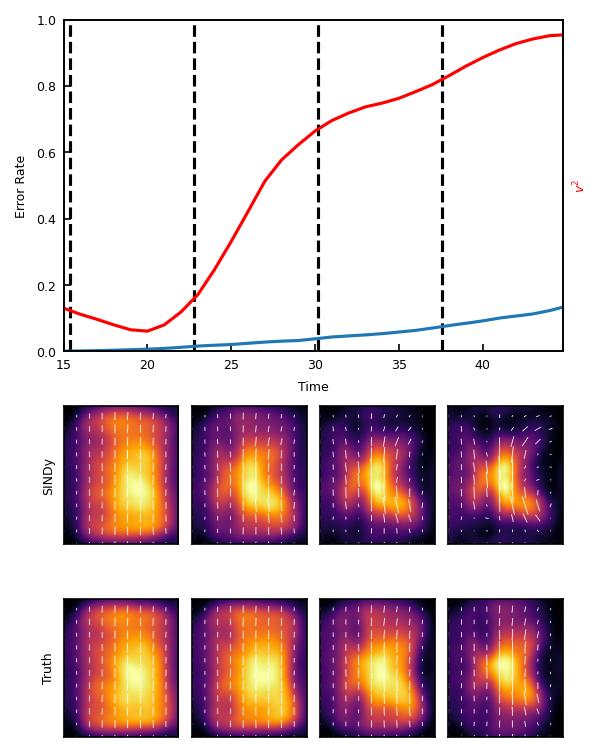

In [156]:
lib_key, lib_path = 'm', 'data/WT/sqh-mCherry'
lib_key, lib_path = 'c', 'data/WT/ECad-GFP'

model = pk.load(open(os.path.join(lib_path, 'tensor_SVDPipeline.pkl'), 'rb'))
info = dict(
    key=lib_key,
    tmin=25,
    tmax=40,
    scale_units=True,
    material_derivative=True,
    n_candidates_to_drop=5,
    n_models=10,
    keep=np.cumsum(model.explained_variance_ratio_) <= 0.9,
    threshold=1e-1,
    alpha=2e-1,
)

with h5py.File('data/symmetric_dynamics_fitting.h5', 'r') as h5f:

    sindy = fit_sindy_model(h5f, **info)
    sindy.print(lhs=['D_t ' + lib_key])
    data = h5f['ensemble']
    tmin, tmax = 15, 45

    pred, interp, times = sindy_predict(data, lib_key, sindy, model, info['keep'], #np.ones_like(info['keep']), 
                                        tmin=tmin, tmax=tmax)
    sindy_predictions_plot(pred, interp, model, times, np.ones_like(info['keep']), data)

results_df.to_csv('SINDy_ensemble_%s.csv' % lib_key)

In [157]:
lib_key, lib_path = 'm', 'data/WT/sqh-mCherry'
lib_key, lib_path = 'c', 'data/WT/ECad-GFP'

model = pk.load(open(os.path.join(lib_path, 'tensor_SVDPipeline.pkl'), 'rb'))
info = dict(
    key=lib_key,
    tmin=25,
    tmax=40,
    scale_units=False,
    material_derivative=True,
    n_candidates_to_drop=5,
    n_models=10,
    keep=np.cumsum(model.explained_variance_ratio_) <= 0.9,
)

from itertools import product
thresholds = np.geomspace(1e-2, 5e-1, 5)
alphas = np.geomspace(1e-2, 5e-1, 5)
scale_units = [True, False]

results_df = pd.DataFrame()
import warnings
warnings.filterwarnings('ignore')
with h5py.File('data/symmetric_dynamics_fitting.h5', 'r') as h5f:
    for threshold, alpha, scale_unit in product(thresholds, alphas, scale_units):
        info['threshold'] = threshold
        info['alpha'] = alpha
        info['scale_units'] = scale_unit

        sindy = fit_sindy_model(h5f, **info)
        features = ['coef_%s' % feature for feature in sindy.feature_names]
        coef_list = np.stack(sindy.optimizer.coef_list + [sindy.optimizer.coef_,])[:, 0]
        df = pd.DataFrame(data=coef_list, columns=features)
        df['threshold'] = info['threshold']
        df['alpha'] = info['alpha']
        df['scale_units'] = info['scale_units']
        df['material_derivative'] = sindy.material_derivative_
        df['key'] = lib_key
        results_df = results_df.append(df, ignore_index=True)

results_df.to_csv('SINDy_ensemble_%s.csv' % lib_key)

/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.18803015465431966) and eliminated all coefficients
  "coefficients".format(self.threshold)
/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.18803015465431966) and eliminated all coefficients
  "coefficients".format(self.threshold)
/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.18803015465431966) and eliminated all coefficients
  "coefficients".format(self.threshold)
/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.18803015465431966) and eliminated all coefficients
  "coefficients".format(self.threshold)
/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity 

Text(0.5, 1.0, 'Myosin statistics')

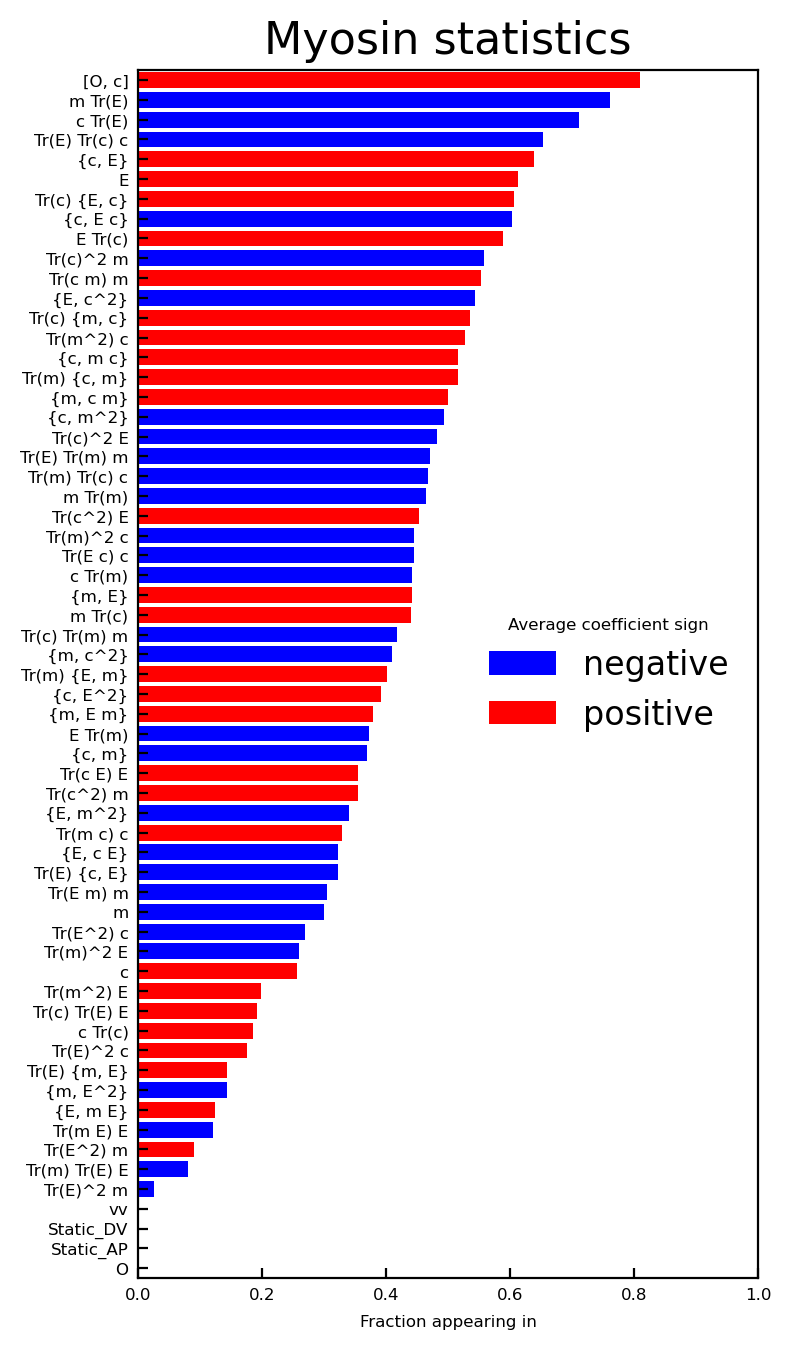

In [195]:
lib_key = 'm'

results_df = pd.read_csv('SINDy_ensemble_%s.csv' % lib_key)
results_df = results_df[results_df.residual != 0]
coefs = results_df.filter(like='coef_')
to_remove = np.sum(coefs.values, axis=1) == 0
results_df = results_df[~to_remove]
results_df = results_df.loc[:, ~results_df.columns.str.contains('^Unnamed')].reset_index()
results_df = pd.wide_to_long(results_df, stubnames='coef', i='index', j='feature', sep='_', suffix='.*')
summary = results_df.groupby('feature')['coef'].agg(
    frac_nonzero=lambda x: np.count_nonzero(x) / len(x),
    count_nonzero=np.count_nonzero, 
    count=lambda x: len(x), 
    mean_nonzero=lambda x: np.mean(x[x != 0]), 
    std_nonzero=lambda x: np.std(x[x != 0]),
    sign=lambda x: np.sign(np.mean(x[x != 0])),
).reset_index()
summary = summary.sort_values('frac_nonzero', ascending=True).reset_index(drop=True)
colors = np.zeros([len(summary), 3])
colors[summary.sign < 0, 0] = 1.
colors[summary.sign > 0, 2] = 1
fig, ax = plt.subplots(1, 1, figsize=(4, 8), dpi=200)
ax.barh(
    summary[summary.sign < 0].index,
    summary[summary.sign < 0].frac_nonzero,
    color='blue',
    label='negative'
)
ax.barh(
    summary[summary.sign > 0].index,
    summary[summary.sign > 0].frac_nonzero,
    color='red',
    label='positive'
)
ax.set(yticks=summary.index, yticklabels = summary.feature)
ax.set_ylim([summary.index.min()-0.5, summary.index.max()+0.5])
ax.set_xlim([0, 1])
ax.set_xlabel('Fraction appearing in')
ax.set_ylabel('')
ax.legend(loc='center right', framealpha=0, fontsize=12, title='Average coefficient sign')
ax.set_title('%s statistics' % ('Myosin' if lib_key == 'm' else 'Cadherin'),
             fontsize=16)

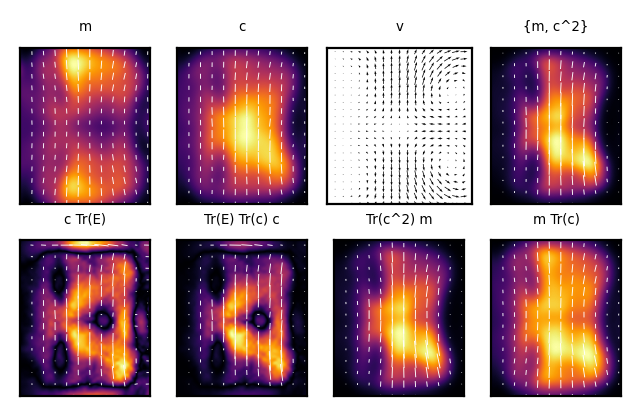

In [200]:
lib_key = 'c'

results_df = pd.read_csv('SINDy_ensemble_%s.csv' % lib_key)
results_df = results_df[results_df.residual != 0]
coefs = results_df.filter(like='coef_')
to_remove = np.sum(coefs.values, axis=1) == 0
results_df = results_df[~to_remove]
results_df = results_df.loc[:, ~results_df.columns.str.contains('^Unnamed')].reset_index()
results_df = pd.wide_to_long(results_df, stubnames='coef', i='index', j='feature', sep='_', suffix='.*')
summary = results_df.groupby('feature')['coef'].agg(
    frac_nonzero=lambda x: np.count_nonzero(x) / len(x),
    count_nonzero=np.count_nonzero, 
    count=lambda x: len(x), 
    mean_nonzero=lambda x: np.mean(x[x != 0]), 
    std_nonzero=lambda x: np.std(x[x != 0]),
    sign=lambda x: np.sign(np.mean(x[x != 0])),
).reset_index()
summary = summary.sort_values('frac_nonzero', ascending=False).reset_index(drop=True)
keys = summary[:5].feature.values

from math import ceil
from utils.plot_utils import *

traj = 0
tt = 30
skip = 16
plt.rcParams['font.size'] = 4
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'inferno'

with h5py.File('data/symmetric_dynamics_fitting.h5', 'r') as h5f:
    embryoID = 'ensemble'
    lib = h5f[embryoID]
    ti = np.argmin(np.abs(lib['t'][()] - tt))
    
    n_plots = 3 + len(keys)

    n_cols = 4
    n_rows = ceil(n_plots / n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, 
                       figsize=(.8*n_cols, n_rows),
                       sharey=True, sharex=True, dpi=200)

    ax = ax.flatten()
    ax[0].set_title('m')
    plot_tensor2D(ax[0], lib['fields/m'][ti][()][..., 10:-10, 10:-10], skip=skip)
    ax[1].set_title('c')
    plot_tensor2D(ax[1], lib['fields/c'][ti][()][..., 10:-10, 10:-10], skip=skip)
    ax[2].set_title('v')
    plot_vector2D(ax[2], lib['fields/v'][ti][()][..., 10:-10, 10:-10])
    
    for i, key in enumerate(keys):
        if key == 'O':
            color_2D(ax[i+3], lib['X_raw'][key][ti][0, 1, 10:-10, 10:-10], cmap='bwr')
        elif key in lib['X_raw']:
            plot_tensor2D(ax[i+3], lib['X_raw'][key][ti][()][..., 10:-10, 10:-10], skip=skip, linewidth=0.007)
        ax[i+3].set_title(key)

    plt.tight_layout()

# Decomposition on datasets

Rather than use the VAEs, we're going to attempt a linear method and perform PCA on the data directly

In [5]:
transform = Reshape2DField()

cad_dataset = AtlasDataset('WT', 'ECad-GFP', 'tensor2D', transform=transform)
vel_dataset = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)
sqh_dataset = AtlasDataset('WT', 'sqh-mCherry', 'tensor2D', transform=transform)
runt_dataset = AtlasDataset('WT', 'Runt', 'raw2D', transform=transform)
rvel_dataset = AtlasDataset('WT', 'Runt', 'velocity2D', transform=transform)
sqh_model, sqh_df = get_decomposition_results(sqh_dataset)
cad_model, cad_df = get_decomposition_results(cad_dataset)
vel_model, vel_df = get_decomposition_results(vel_dataset)

100%|██████████| 6/6 [00:00<00:00, 11.39it/s]


Found SVDPipeline for this dataset!
Found SVDPipeline for this dataset!
Found SVDPipeline for this dataset!


## Tensor datasets

In [6]:
dataset = AtlasDataset('WT', 'sqh-mCherry', 'tensor2D', transform=transform)
info = get_decomposition_results(dataset)
print('%d components explain 90%% of dataset variance' % np.argwhere(np.cumsum(info[0].explained_variance_ratio_) >= 0.9)[0, 0])
print('%d components explain 95%% of dataset variance' % np.argwhere(np.cumsum(info[0].explained_variance_ratio_) >= 0.95)[0, 0])

#decomposition_point_plot(*info, cutoff=0.9)
#decomposition_sweep_plot(*info, cutoff=0.9, plot_fn=plot_tensor2D)

100%|██████████| 21/21 [00:00<00:00, 331.87it/s]

Found SVDPipeline for this dataset!
6 components explain 90% of dataset variance
14 components explain 95% of dataset variance


In [17]:
dataset = AtlasDataset('WT', 'ECad-GFP', 'tensor2D', transform=transform)
info = get_decomposition_results(dataset)
print('%d components explain 90%% of dataset variance' % np.argwhere(np.cumsum(info[0].explained_variance_ratio_) >= 0.9)[0, 0])
print('%d components explain 95%% of dataset variance' % np.argwhere(np.cumsum(info[0].explained_variance_ratio_) >= 0.95)[0, 0])

#decomposition_point_plot(*info, cutoff=0.9)
#decomposition_sweep_plot(*info, cutoff=0.9, plot_fn=plot_tensor2D)

100%|██████████| 6/6 [00:00<00:00, 571.91it/s]

Found SVDPipeline for this dataset!
3 components explain 90% of dataset variance
5 components explain 95% of dataset variance


## Velocity datasets

In [16]:
dataset = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)
info = get_decomposition_results(dataset)
print('%d components explain 90%% of dataset variance' % np.argwhere(np.cumsum(info[0].explained_variance_ratio_) >= 0.9)[0, 0])
print('%d components explain 95%% of dataset variance' % np.argwhere(np.cumsum(info[0].explained_variance_ratio_) >= 0.95)[0, 0])

#decomposition_point_plot(*info, cutoff=0.9)
#decomposition_sweep_plot(*info, cutoff=0.9, plot_fn=plot_vector2D)

100%|██████████| 6/6 [00:00<00:00, 578.99it/s]

Found SVDPipeline for this dataset!
6 components explain 90% of dataset variance
12 components explain 95% of dataset variance


## Scalar datasets

In [ ]:
dataset = AtlasDataset('WT', 'Runt', 'raw2D', transform=transform)
info = get_decomposition_results(dataset, n_components=32)
print('%d components explain 90%% of dataset variance' % np.argwhere(np.cumsum(info[0].explained_variance_ratio_) >= 0.9)[0, 0])
print('%d components explain 95%% of dataset variance' % np.argwhere(np.cumsum(info[0].explained_variance_ratio_) >= 0.95)[0, 0])
#pca_summary_plot(*info, dataset, 5, show_magnitude=True, cutoff=0.9, plot_fn=color_2D)
#pca_point_plot(*runt_info, cutoff=0.9)
#pca_sweep_plot(*runt_info, cutoff=0.9, plot_fn=color_2D)

100%|██████████| 6/6 [00:00<00:00, 530.53it/s]


Overwriting SVDPipeline for this dataset
15 components explain 90% of dataset variance
28 components explain 95% of dataset variance


In [ ]:
dataset = AtlasDataset('WT', 'Even_Skipped', 'raw2D', drop_no_time=False, transform=transform)
info = get_decomposition_results(dataset, n_components=32)
print('%d components explain 90%% of dataset variance' % np.argwhere(np.cumsum(info[0].explained_variance_ratio_) >= 0.9)[0, 0])
print('%d components explain 95%% of dataset variance' % np.argwhere(np.cumsum(info[0].explained_variance_ratio_) >= 0.95)[0, 0])
#pca_summary_plot(*info, eve_dataset, 5, show_magnitude=True, cutoff=0.9, plot_fn=color_2D)

100%|██████████| 1/1 [00:00<00:00, 395.13it/s]


Overwriting SVDPipeline for this dataset
10 components explain 90% of dataset variance
16 components explain 95% of dataset variance


In [ ]:
dataset = AtlasDataset('WT', 'moesin-GFP', 'tensor2D', drop_no_time=False, transform=transform)
info = get_decomposition_results(dataset, n_components=16)
print('%d components explain 90%% of dataset variance' % np.argwhere(np.cumsum(info[0].explained_variance_ratio_) >= 0.9)[0, 0])
print('%d components explain 95%% of dataset variance' % np.argwhere(np.cumsum(info[0].explained_variance_ratio_) >= 0.95)[0, 0])
#pca_summary_plot(*info, dataset, 5, show_magnitude=True, cutoff=0.9, plot_fn=plot_tensor2D)

100%|██████████| 11/11 [00:00<00:00, 18.28it/s]


Building SVDPipeline for this dataset
7 components explain 90% of dataset variance
14 components explain 95% of dataset variance


In [ ]:
dataset = AtlasDataset('WT', 'histone-RFP', 'raw2D', drop_no_time=False, transform=transform)
info = get_decomposition_results(dataset, n_components=40)
print('%d components explain 90%% of dataset variance' % np.argwhere(np.cumsum(info[0].explained_variance_ratio_) >= 0.9)[0, 0])
print('%d components explain 95%% of dataset variance' % np.argwhere(np.cumsum(info[0].explained_variance_ratio_) >= 0.95)[0, 0])
#pca_summary_plot(*info, dataset, 5, show_magnitude=True, cutoff=0.9, plot_fn=color_2D)

100%|██████████| 5/5 [00:00<00:00, 20.71it/s]


Building SVDPipeline for this dataset
10 components explain 90% of dataset variance
13 components explain 95% of dataset variance


# Runt dynamics

We expect pair rule gene stripes to be advected by the flow, i.e. $\partial_t R + \mathbf{v} \cdot \nabla R = 0$

## PCA Information

       time
set        
test    199
train   299


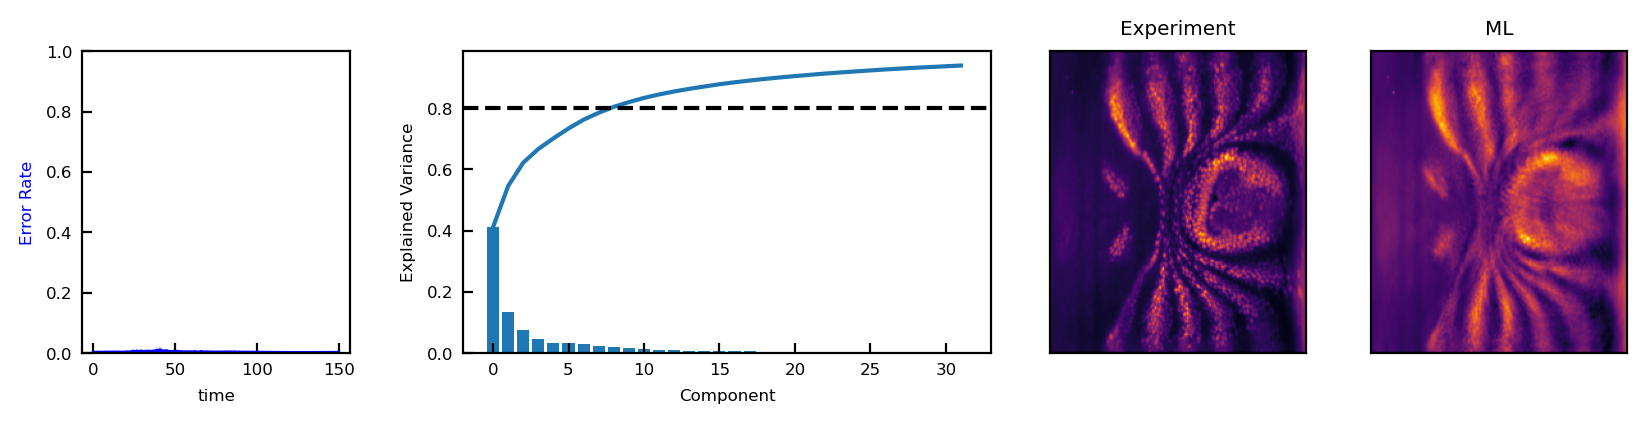

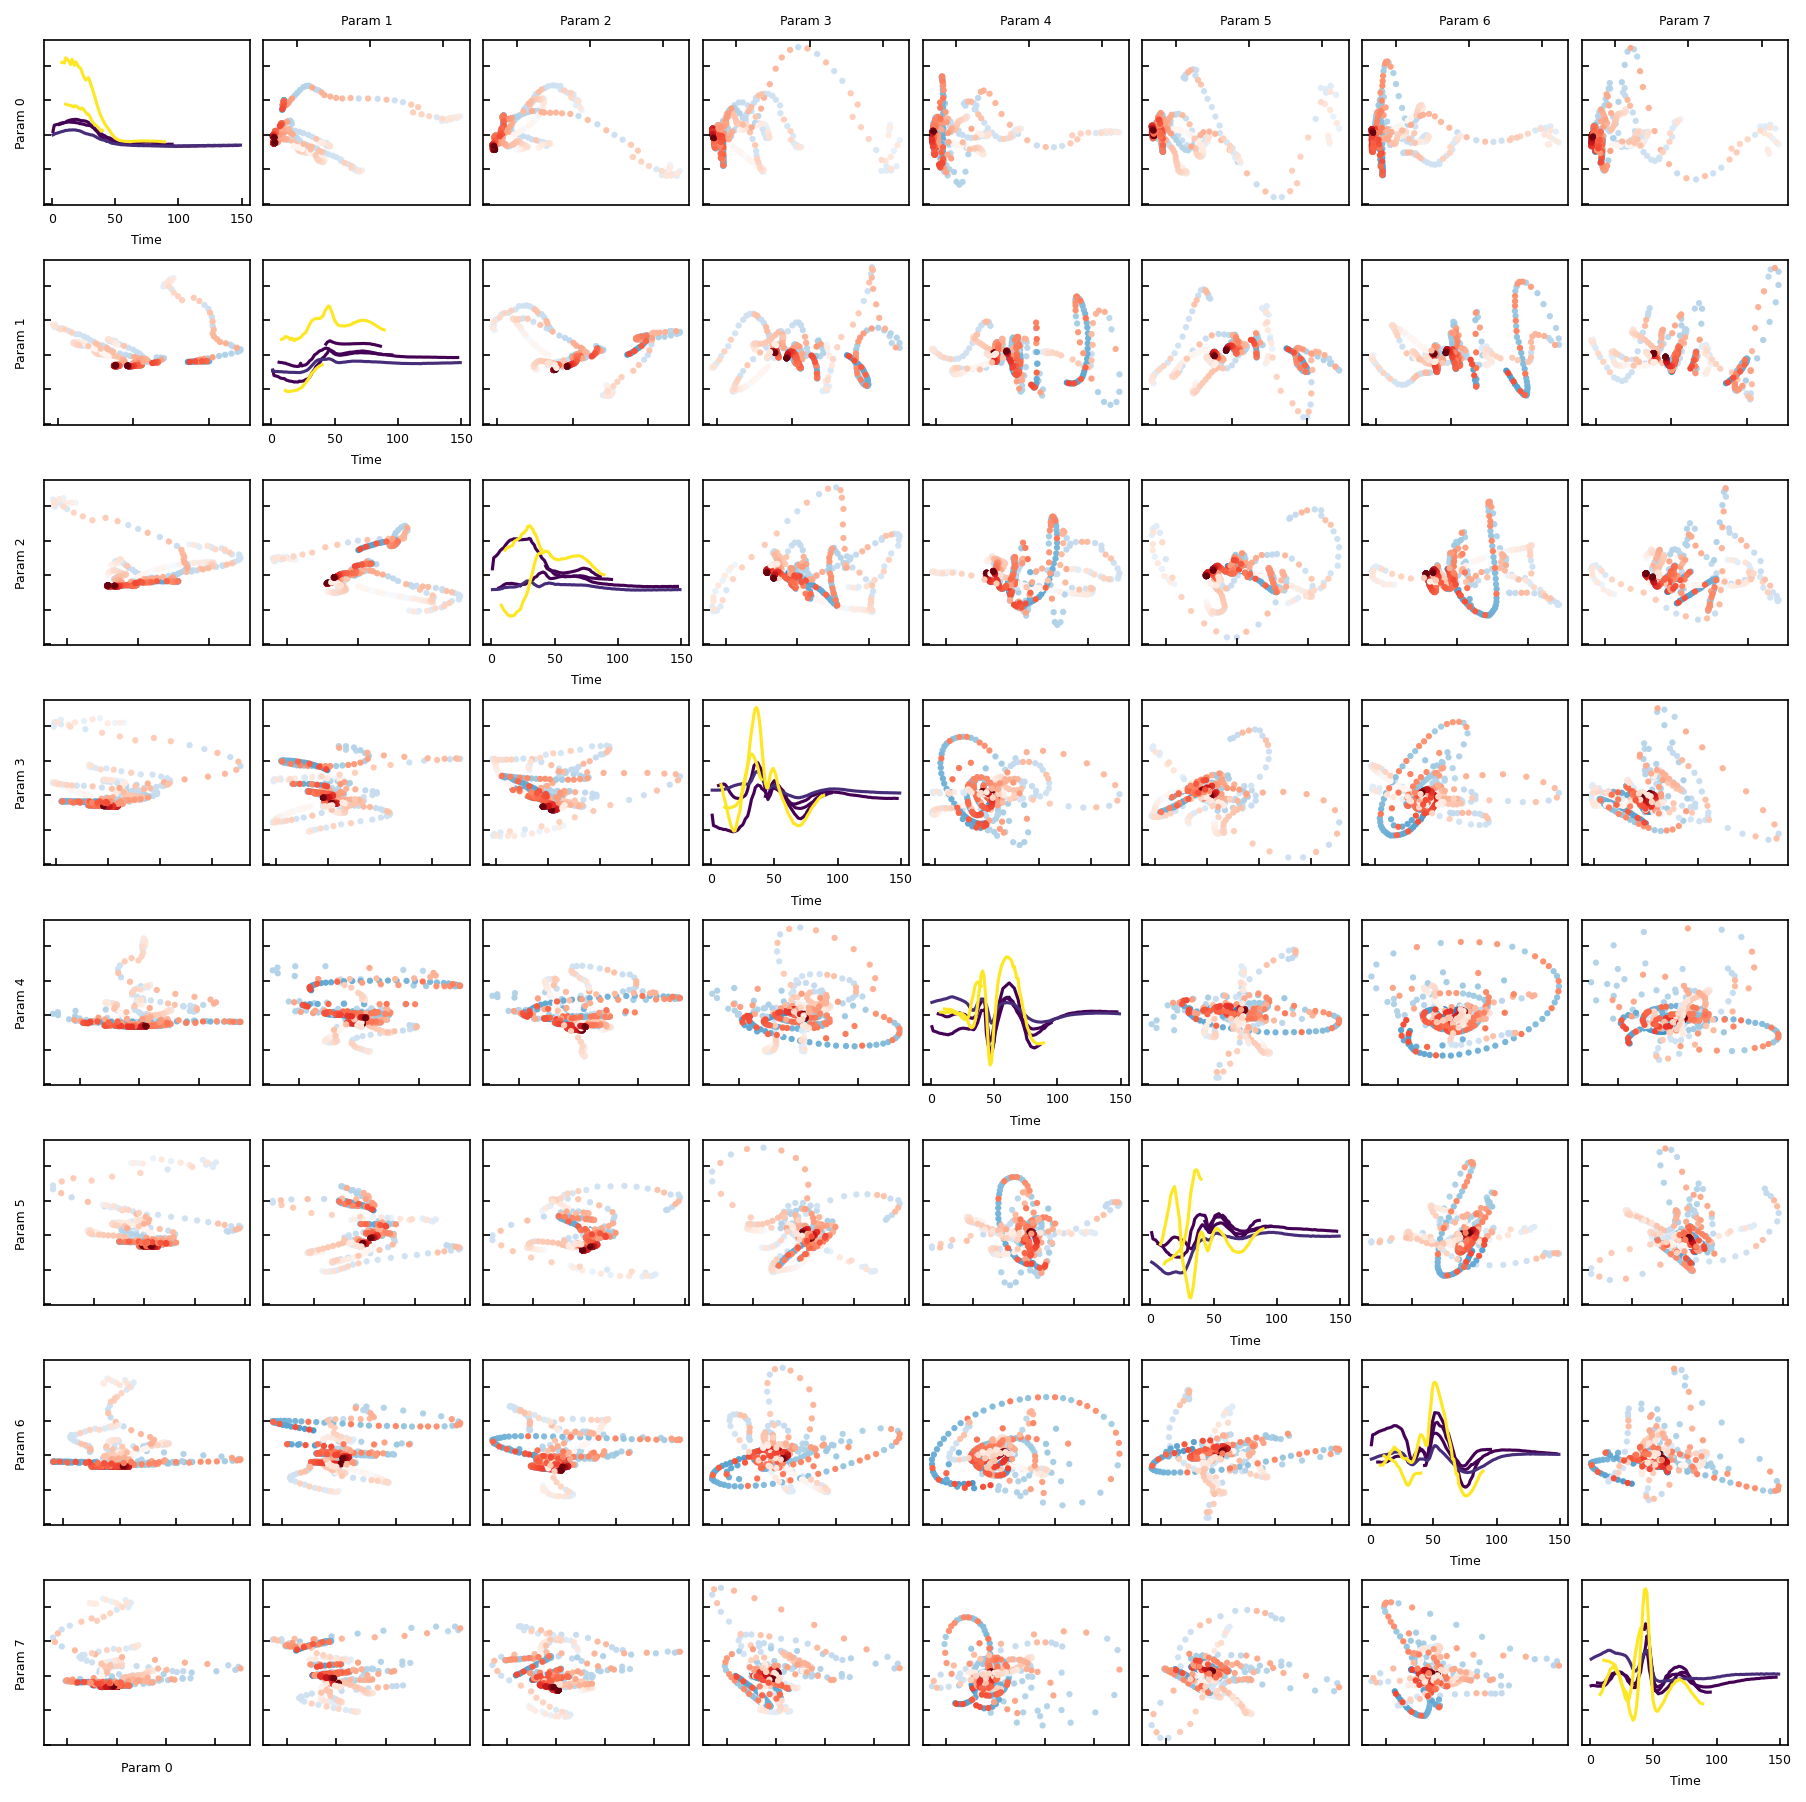

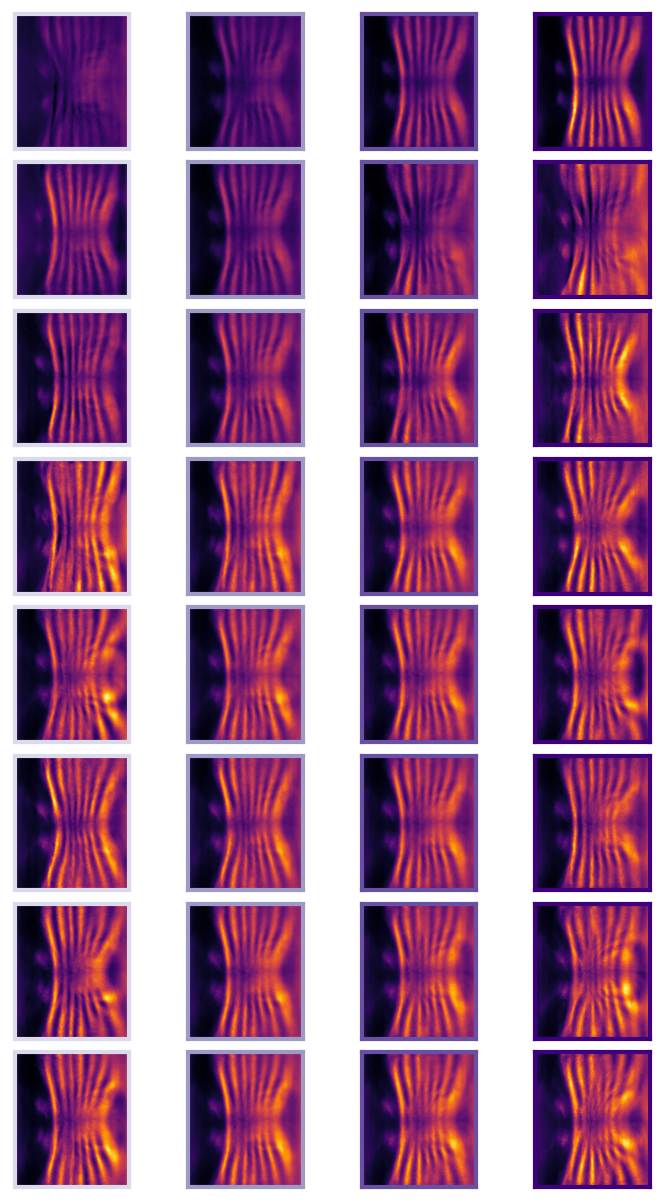

In [7]:
runt_model, runt_df = get_results(runt_dataset, n_components=32, whiten=True)
plot_fn = color_2D
summary_plot(runt_df, runt_model, runt_dataset, 25, show_magnitude=False, cutoff=0.8)
pca_plots(runt_df, runt_model, cutoff=0.8)

       time
set        
test    199
train   299


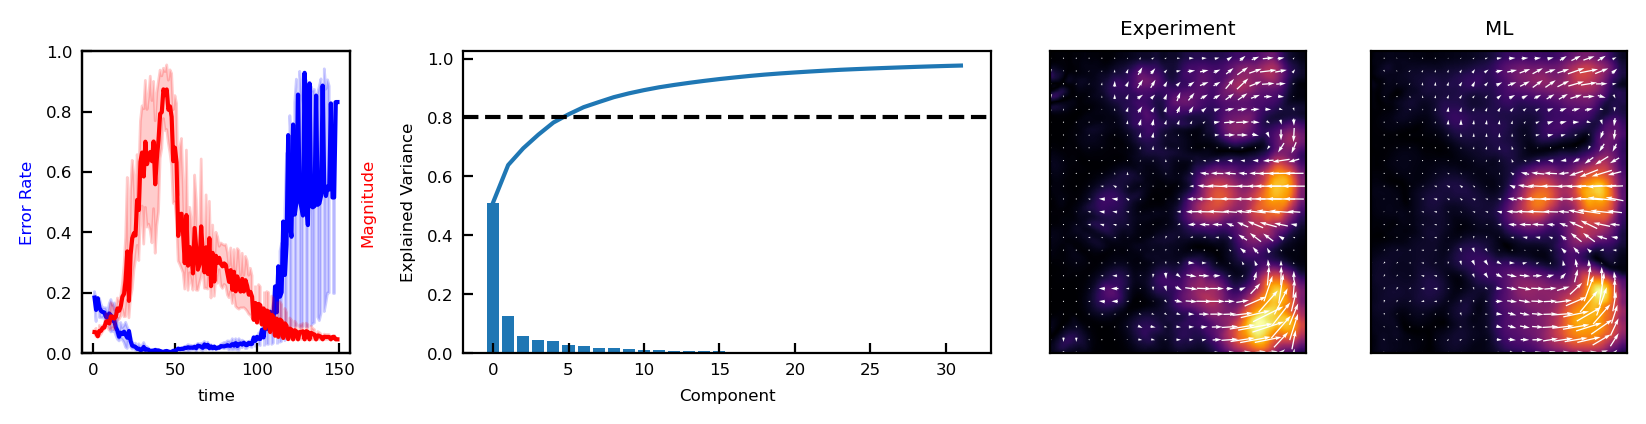

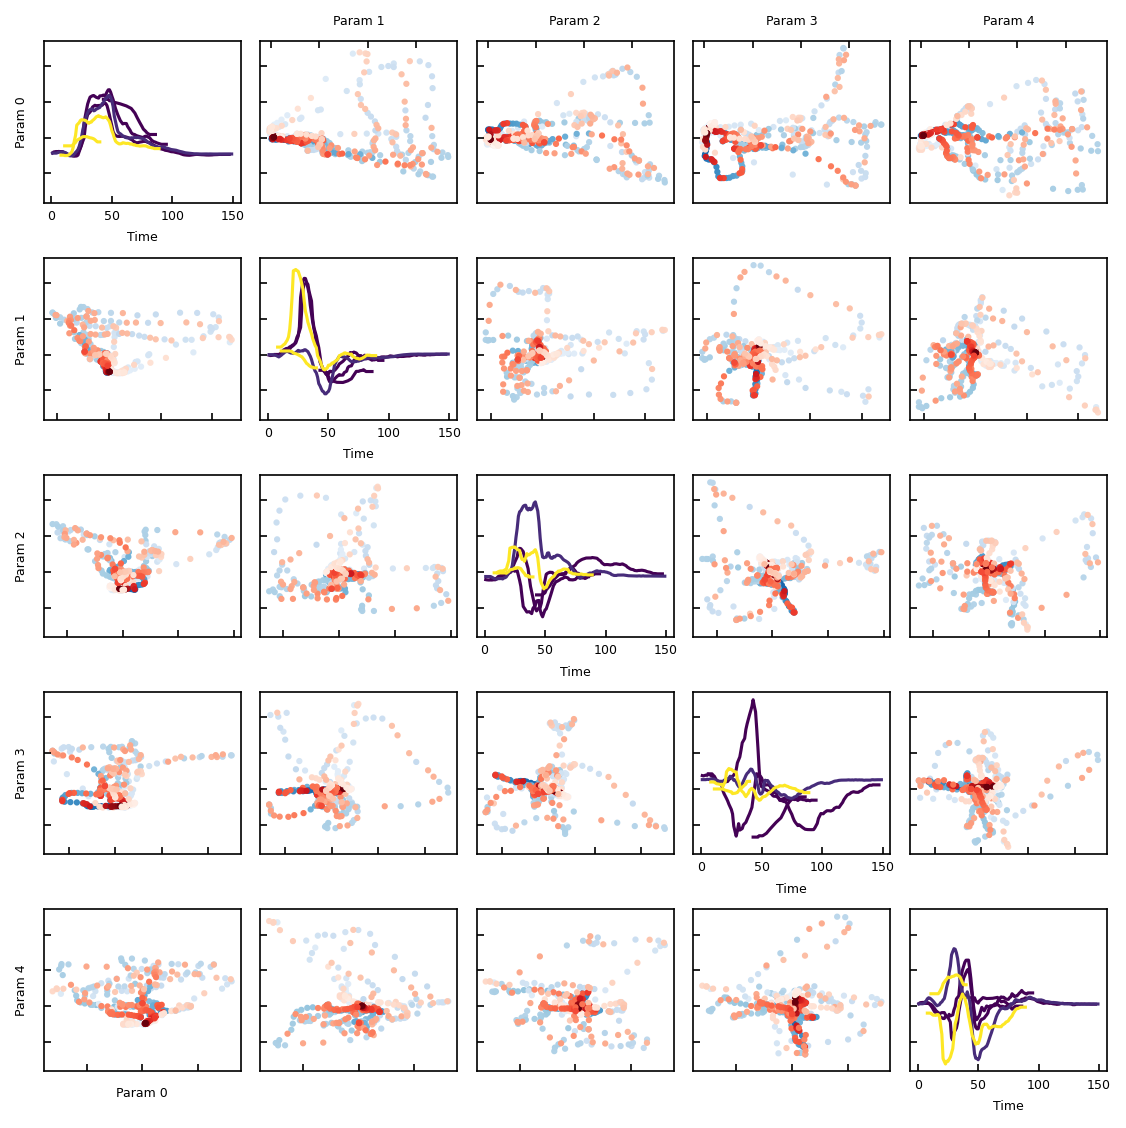

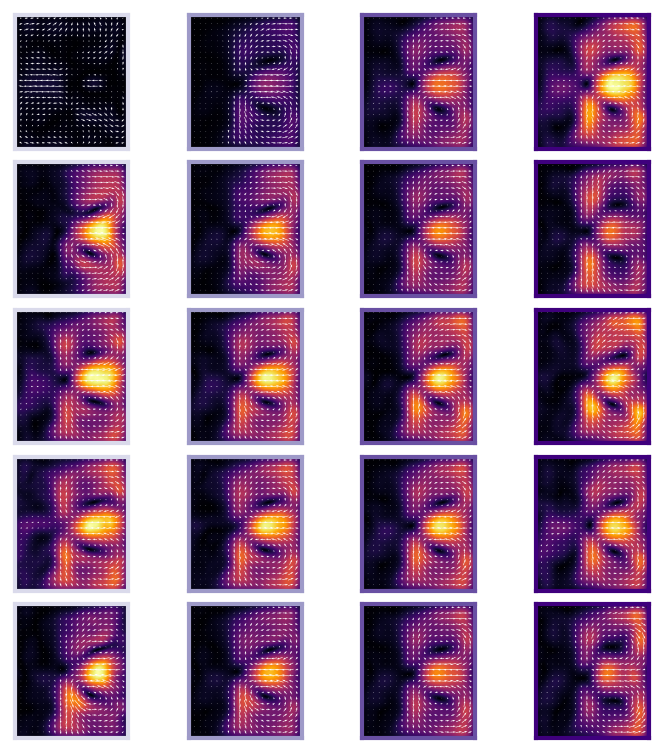

In [8]:
rvel_model, rvel_df = get_results(rvel_dataset, n_components=32, whiten=True)
plot_fn = plot_vector2D
summary_plot(rvel_df, rvel_model, rvel_dataset, 25, show_magnitude=True, cutoff=0.8)
pca_plots(rvel_df, rvel_model, cutoff=0.8)

## SINDy in PCA basis

In [282]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import pysindy as ps
from pysindy.feature_library.pde_library import PDELibrary

from scipy.io import loadmat
geometry = loadmat('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/minimalData/vitelli_sharing/pixel_coordinates.mat')
XX, YY = geometry['XX'][0, :], geometry['YY'][:, 0]

'''
Step 1. Choose datasets to use
'''
x_model, x_df = runt_model, runt_df.reset_index(drop=True)
u_model, u_df = rvel_model, rvel_df.reset_index(drop=True)

params_x = x_df.filter(like='param', axis=1).values
params_u = u_df.filter(like='param', axis=1).values

'''
Step 2. Establish component cutoff 
    Here, this is some threshold for the explained variance ratio
'''
keep_x = np.cumsum(x_model.explained_variance_ratio_) <= 0.9
keep_x[:2] = False #For runt, ignore the first two principal components
keep_u = np.cumsum(u_model.explained_variance_ratio_) <= 0.9

'''
Step 3. Project terms onto subset of meaningful components
'''

X = unpca(params_x[:, keep_x], x_model, keep_x)
U = unpca(params_u[:, keep_u], u_model, keep_u)

'''
Step 4. Compute derivatives
'''

#Split by embryo
diffY = ps.SmoothedFiniteDifference(d=1, axis=0)
diffX = ps.SmoothedFiniteDifference(d=1, axis=1)
diffT = ps.SmoothedFiniteDifference(d=1, axis=2)

tmin = 20
tmax = 90


feature_names = [
    'r',
    'grad^2 r',
    '(grad r)^2',
    'v^2', 
    'div v',
    'v grad r',
]

t = []
x = []
x_dot = []
x_true = []
u_true = []
for i, eID in enumerate(u_df.embryoID.unique()):
    data = u_df[u_df.embryoID == eID]
    data = data[(data.t >= tmin) & (data.t <= tmax)]
    idx = data.index

    if len(idx) < 30:
        continue
    
    xi = X[idx].transpose(2, 3, 0, 1)
    ui = U[idx].transpose(2, 3, 0, 1)
        
    x_dot.append(diffT._differentiate(xi, data.t.values))
    t.append(data.t.values)
    lib = []
    
    lib.append(xi)
    x_true.append(xi)
    u_true.append(ui)

    
    grad_x = np.stack([
        diffY._differentiate(xi, YY),
        diffX._differentiate(xi, XX),
    ], axis=-1)
    
    lapl_x = diffY._differentiate(grad_x[..., 0], YY) + \
             diffX._differentiate(grad_x[..., 1], XX)
    lib.append(lapl_x)
    
    grad2_x = np.power(grad_x, 2).sum(axis=-1)
    lib.append(grad2_x)
    
    u2 = np.power(ui, 2).sum(axis=-1, keepdims=True)
    lib.append(u2)
    
    grad_u = np.stack([
        diffY._differentiate(ui, YY),
        diffX._differentiate(ui, XX),
    ], axis=-1)
    
    div_u = grad_u[..., 0, 0:1] + grad_u[..., 1, 1:2]
    lib.append(div_u)
    
    u_grad_x = ui[..., 0:1] * grad_x[..., 0] + \
               ui[..., 1:2] * grad_x[..., 1]
    
    lib.append(u_grad_x)
    
    lib = np.concatenate(lib, axis=-1)
    print(lib.shape)
    
    x.append(lib.reshape([-1, lib.shape[-1]]))
    x_dot[-1] = x_dot[-1].reshape([-1, x_dot[-1].shape[-1]])
        
'''
Step 5. Fit model using SINDy
'''
model = ps.SINDy(
    feature_library=ps.IdentityLibrary(),
    optimizer=ps.STLSQ(threshold=0.5, alpha=0.),
    feature_names=feature_names
)

model.fit(x=x, x_dot=x_dot, multiple_trajectories=True)
model.print()

(236, 200, 71, 6)
(236, 200, 59, 6)
(236, 200, 63, 6)
(236, 200, 74, 6)
(r)' = 0.798 grad^2 r + -1.049 v grad r


In [283]:
from scipy.interpolate import interp1d

def evolve_rk4_grid(x0, xdot, pca, t, tmin=0, tmax=10, step_size=0.2):
    tt = np.arange(tmin, tmax, step_size)
    x = np.zeros([len(tt), *x0.shape])
    x[0] = x0
    
    print(x0.shape)
        
    interp = interp1d(t, xdot, axis=-2)
    for ii in range(len(tt)-1):
        k1 = interp(tt[ii])
        k2 = interp(tt[ii] + 0.5 * step_size)
        k3 = interp(tt[ii] + 0.5 * step_size)
        k4 = interp(tt[ii] + step_size)
        
        xtt = x[ii] + (k1 + 2 * k2 + 2 * k3 + k4) * step_size / 6
        
        #Project onto PCA components
        xtt = xtt.transpose(2, 0, 1).reshape([1, -1])
        xtt = unpca(pca.transform(xtt)[:, keep_x], pca, keep_x)[0]
        #xtt = xtt.transpose(1, 2, 0)
        x[ii+1] = xtt.transpose(1, 2, 0)

        
    return x.transpose(1, 2, 0, 3), tt

traj = 1
t0 = 25
dt = 25

x_dot_pred = model.model.predict(x[traj])
x_int = interp1d(t[traj], x_true[traj], axis=-2)
u_int = interp1d(t[traj], u_true[traj], axis=-2)
ic = x_int(t0)
x_dot_pred = x_dot_pred.reshape([*ic.shape[:-1], -1, 1])

x_pred, times = evolve_rk4_grid(ic, x_dot_pred, x_model, 
                                t=t[traj], tmin=t0, tmax=t0+dt)

(236, 200, 1)


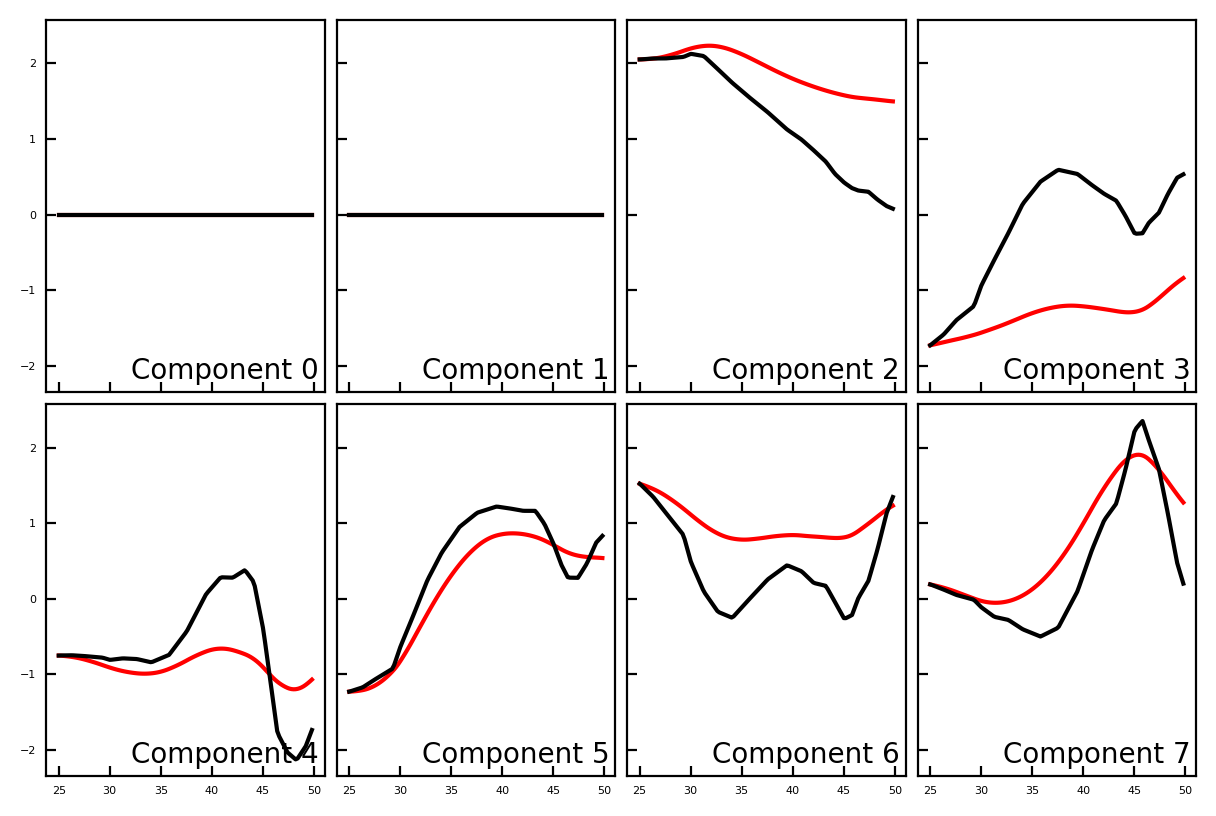

In [284]:
pca_pred = x_model.transform(x_pred.transpose(2, 3, 0, 1).reshape([x_pred.shape[-2], -1]))
pca_true = x_model.transform(x_int(times).transpose(2, 3, 0, 1).reshape([pca_pred.shape[0], -1]))

subset = np.cumsum(x_model.explained_variance_ratio_) <= 0.8

pca_pred = pca_pred[:, subset]
pca_true = pca_true[:, subset]

ncols = 4
fig, ax = plt.subplots(pca_pred.shape[1] // ncols, ncols, 
                       sharey=True, sharex=True, dpi=200)
ax = ax.flatten()

for i in range(len(ax)):
    ax[i].plot(times, pca_pred[:, i], color='red')
    ax[i].plot(times, pca_true[:, i], color='black')
    ax[i].text(0.98, 0.02, 'Component %d' % i, fontsize=10, 
               transform=ax[i].transAxes, va='bottom', ha='right')
plt.tight_layout()

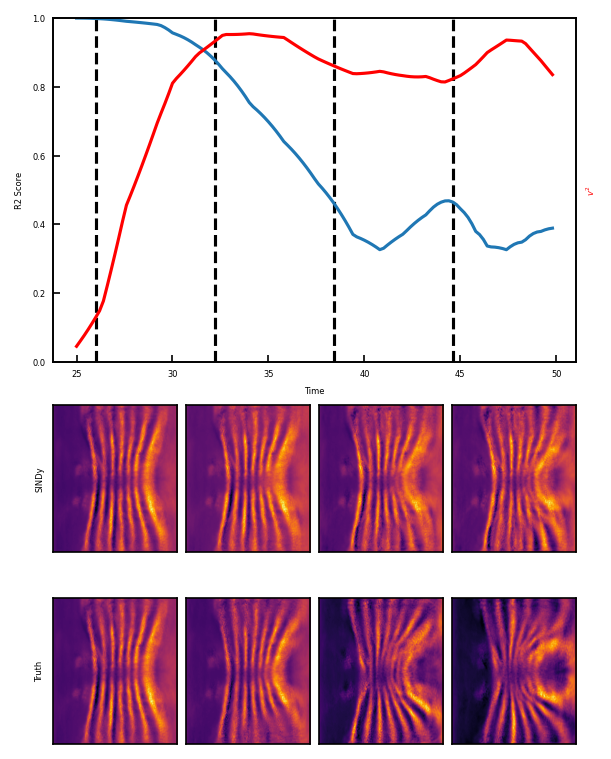

In [285]:
ncols = 4
step = x_pred.shape[-2] // ncols

fig = plt.figure(dpi=150, figsize=(1*ncols, 5))
gs = fig.add_gridspec(4, ncols)

plot_fn = color_2D
ax = fig.add_subplot(gs[:2, :])

from sklearn.metrics import r2_score

error = r2_score(
    x_pred.reshape([-1, x_pred.shape[-2]]),
    x_int(times).reshape([-1, x_pred.shape[-2]]),
    multioutput='raw_values'
)

v2 = np.linalg.norm(u_int(times), axis=-1).mean(axis=(0, 1))

ax.plot(times, error)
ax.set(ylim=[0, 1],
       ylabel='R2 Score',
       xlabel='Time')
ax2 = ax.twinx()
ax2.plot(times, v2, color='red')
ax2.set_yticks([])
ax2.set_ylabel('$v^2$', color='red')


offset = 5
for i in range(ncols):
    ii = i*step + offset
    color_2D(fig.add_subplot(gs[2, i]), x_pred[..., ii, 0])
    if i == 0:
        plt.gca().set_ylabel('SINDy')
    color_2D(fig.add_subplot(gs[3, i]), x_int(times[ii])[..., 0])
    if i == 0:
        plt.gca().set_ylabel('Truth')
    ax.axvline(times[ii], zorder=-1, color='black', linestyle='--')
    
plt.tight_layout()

## SINDy with PCA TransformedTarget Regressor

In [434]:
from sklearn.model_selection import train_test_split
import pysindy as ps
from pysindy.feature_library.pde_library import PDELibrary

from scipy.io import loadmat
geometry = loadmat('/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/minimalData/vitelli_sharing/pixel_coordinates.mat')
XX, YY = geometry['XX'][0, :], geometry['YY'][:, 0]

'''
Step 1. Choose datasets to use
'''
x_model, x_df = runt_model, runt_df.reset_index(drop=True)
u_model, u_df = rvel_model, rvel_df.reset_index(drop=True)

params_x = x_df.filter(like='param', axis=1).values
params_u = u_df.filter(like='param', axis=1).values

'''
Step 2. Establish component cutoff 
    Here, this is some threshold for the explained variance ratio
'''
keep_x = np.cumsum(x_model.explained_variance_ratio_) <= 0.9
keep_u = np.cumsum(u_model.explained_variance_ratio_) <= 0.9

'''
Step 3. Project terms onto subset of meaningful components
'''

X = unpca(params_x[:, keep_x], x_model, keep_x)
U = unpca(params_u[:, keep_u], u_model, keep_u)

'''
Step 4. Compute derivatives
'''

#Split by embryo
diffT = ps.SmoothedFiniteDifference(d=1, axis=0)
diffY = ps.SmoothedFiniteDifference(d=1, axis=-2)
diffX = ps.SmoothedFiniteDifference(d=1, axis=-1)

tmin = 20
tmax = 90


feature_names = [
    'r',
    'grad^2 r',
    '(grad r)^2',
    'v^2', 
    'div v',
    'v grad r',
]

t = []
x = []
x_dot = []
x_true = []
u_true = []
for i, eID in enumerate(u_df.embryoID.unique()):
    data = u_df[u_df.embryoID == eID]
    data = data[(data.t >= tmin) & (data.t <= tmax)]
    idx = data.index

    if len(idx) < 30:
        continue
    
    xi = X[idx]
    ui = U[idx]
        
    x_dot.append(diffT._differentiate(xi, data.t.values)[..., None])
    t.append(data.t.values)

    x_true.append(xi)
    u_true.append(ui)
    
    '''
    Pure scalar terms
    '''

    
    grad_x = np.stack([
        diffY._differentiate(xi, YY),
        diffX._differentiate(xi, XX),
    ], axis=-1)
    
    lapl_x = diffY._differentiate(grad_x[..., 0], YY) + \
             diffX._differentiate(grad_x[..., 1], XX)
    
    grad2_x = np.power(grad_x, 2).sum(axis=-1)
    
    '''
    Pure vector terms
    '''
    
    u2 = np.power(ui, 2).sum(axis=1, keepdims=True)
    
    diffY.axis = -2
    diffX.axis = -1
    
    grad_u = np.stack([
        diffY._differentiate(ui, YY),
        diffX._differentiate(ui, XX),
    ], axis=-1)
    
    div_u = grad_u[:, 0:1, ..., 0] = grad_u[:, 1:2, ..., 1]
    
    '''
    Mixed terms
    '''
    u_grad_x = ui[:, 0:1] * grad_x[..., 0] + \
               ui[:, 1:2] * grad_x[..., 1]
    
    
    lib = []
    lib.append(xi)
    lib.append(lapl_x)
    lib.append(grad2_x)
    lib.append(u2)
    lib.append(div_u)
    lib.append(u_grad_x)
    
    lib = np.stack(lib, axis=-1)    
    x.append(lib)
    print(x_dot[-1].shape, x[-1].shape)

(71, 1, 236, 200, 1) (71, 1, 236, 200, 6)
(59, 1, 236, 200, 1) (59, 1, 236, 200, 6)
(63, 1, 236, 200, 1) (63, 1, 236, 200, 6)
(74, 1, 236, 200, 1) (74, 1, 236, 200, 6)


(71, 1, 236, 200)


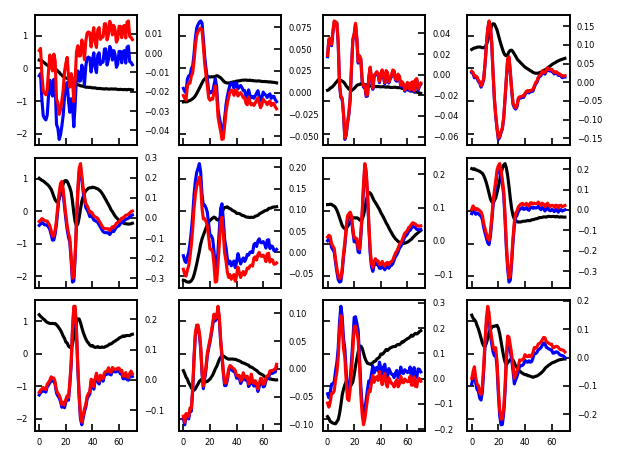

In [435]:
#Check that PCA behaves correctly under differentiation?

traj = 0
xi = x[traj][..., 0]
print(xi.shape)

pca_x = x_model.transform(xi.reshape([xi.shape[0], -1]))
d_pca_x = np.gradient(pca_x, axis=0)

pca_xd = x_model.transform(np.gradient(xi, axis=0).reshape([xi.shape[0], -1]))
pca_xd -= np.mean(pca_xd, axis=0, keepdims=True) #We have to remove bias to make this linear

subset = np.cumsum(x_model.explained_variance_ratio_) <= 0.85

pca_x = pca_x[:, subset]
pca_xd = pca_xd[:, subset]
d_pca_x = d_pca_x[:, subset]

ncols = 4
nrows = ceil(pca_x.shape[1] / ncols)
fig, ax = plt.subplots(nrows, ncols, 
                       figsize=(ncols, nrows),
                       sharey=True, sharex=True, dpi=150)
ax = ax.flatten()

for i in range(ax.shape[0]):
    ax[i].plot(pca_x[:, i], color='black')
    ax2 = ax[i].twinx()
    ax2.plot(d_pca_x[:, i], color='blue')
    ax2.plot(pca_xd[:, i], color='red')
    
plt.tight_layout()

(71, 1, 236, 200, 6)
(71, 236, 200, 7)


feature           min        max      mean       std
0       r_dot  1.253399e-09   0.114951  0.007905  0.010283
1           r  6.773657e-01   2.834998  1.058792  0.146623
2    grad^2 r  3.422747e-10   0.043211  0.001358  0.001795
3  (grad r)^2  1.630450e-12   0.020429  0.000128  0.000376
4         v^2  1.117515e-08  89.209130  1.909595  5.035569
5       div v  0.000000e+00   0.114327  0.005876  0.008417
6    v grad r  1.029143e-10   0.149236  0.004289  0.008396

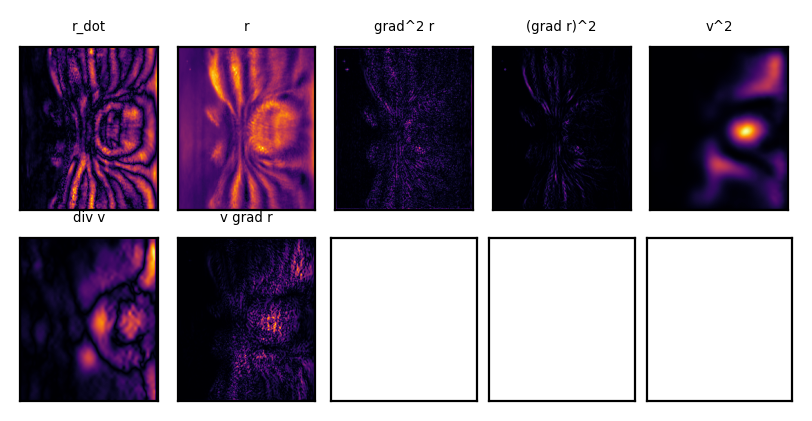

In [436]:
#Show library
from math import ceil

traj = 0
tt = 45

ncols = 5
nrows = ceil((x[traj].shape[-1]+1) / ncols)
fig, ax = plt.subplots(nrows, ncols, 
                       figsize=(.8*ncols, nrows),
                       sharey=True, sharex=True, dpi=200)
ax = ax.flatten()

plt.rcParams['font.size'] = 4

color_2D(ax[0], x_dot[traj][tt, ..., 0])
ax[0].set_title('r_dot')
for i in range(x[traj].shape[-1]):
    color_2D(ax[i+1], x[traj][tt, ..., i])
    ax[i+1].set_title(feature_names[i])

plt.tight_layout()
print(x[0].shape)
fnorm = np.linalg.norm(np.concatenate([x_dot[0], x[0]], axis=-1), axis=(1))
print(fnorm.shape)

df = pd.DataFrame({
    'feature': ['r_dot',] + feature_names,
    'min': np.min(fnorm, axis=(0, 1, 2)),
    'max': np.max(fnorm, axis=(0, 1, 2)),
    'mean': np.mean(fnorm, axis=(0, 1, 2)),
    'std': np.std(fnorm, axis=(0, 1, 2)),
})
df

In [437]:
'''
Step 5. Project library onto PCA basis
'''
def pca_trajectory(x):
    #x shape [T, C, Y, X, L]
    xi = x.transpose(0, 4, 1, 2, 3) # [T, L, C, Y, X]
    xi= xi.reshape([x.shape[0]*x.shape[-1], -1]) # [T*L, C, Y, X]
    xi = x_model.transform(xi) # [T*L, P]
    xi = xi.reshape([x.shape[0], -1, xi.shape[-1]]) # [T, L, P]
    xi -= np.mean(xi, axis=0, keepdims=True)
    xi = xi.transpose(0, 2, 1) #[T, P, L]
    return xi

keep_x = np.zeros(x_model.n_components_, dtype=bool)
keep_x[2:10] = True

x_pca = []
x_dot_pca = []
for i in range(len(x)):
    x_pca.append(pca_trajectory(x[i])[:, keep_x])
    x_dot_pca.append(pca_trajectory(x_dot[i])[:, keep_x])
    print(x[i].shape, x_pca[i].shape)

(71, 1, 236, 200, 6) (71, 8, 6)
(59, 1, 236, 200, 6) (59, 8, 6)
(63, 1, 236, 200, 6) (63, 8, 6)
(74, 1, 236, 200, 6) (74, 8, 6)


In [442]:
'''
Step 6. Fit model using SINDy
'''

model = ps.SINDy(
    feature_library=ps.IdentityLibrary(),
    optimizer=ps.STLSQ(threshold=0.5, alpha=0.1),
    feature_names=feature_names
)

model.fit(x=x_pca, x_dot=x_dot_pca, multiple_trajectories=True)
model.print()

(r)' = 3.573 grad^2 r + -4.487 (grad r)^2 + -3.731 v grad r


In [443]:
from scipy.interpolate import interp1d
from tqdm import tqdm

def evolve_rk4_grid(x0, xdot, pca, t, tmin=0, tmax=10, step_size=0.2):
    tt = np.arange(tmin, tmax, step_size)
    x = np.zeros([len(tt), *x0.shape])
    x[0] = x0
        
    interp = interp1d(t, xdot, axis=0)
    for ii in tqdm(range(len(tt)-1)):
        k1 = interp(tt[ii])
        k2 = interp(tt[ii] + 0.5 * step_size)
        k3 = interp(tt[ii] + 0.5 * step_size)
        k4 = interp(tt[ii] + step_size)
                
        xtt = x[ii] + (k1 + 2 * k2 + 2 * k3 + k4) * step_size / 6
        
        #Project onto PCA components
        xtt = xtt.reshape([1, -1])
        xtt = unpca(pca.transform(xtt)[:, keep_x], pca, keep_x).reshape(x[ii].shape)
        x[ii+1] = xtt

        
    return x, tt


traj = 1
t0 = 25
dt = 25

xi = x[traj]

x_dot_pred = model.model.predict(xi.reshape([-1, xi.shape[-1]])).reshape(x_dot[traj].shape)[..., 0]
print(x_dot_pred.shape)
x_int = interp1d(t[traj], x_true[traj], axis=0)
u_int = interp1d(t[traj], u_true[traj], axis=0)
ic = x_int(t0)

x_pred, times = evolve_rk4_grid(ic, x_dot_pred, x_model, 
                                t=t[traj], tmin=t0, tmax=t0+dt)

(59, 1, 236, 200)


100%|██████████| 124/124 [00:00<00:00, 169.53it/s]


(125, 32)


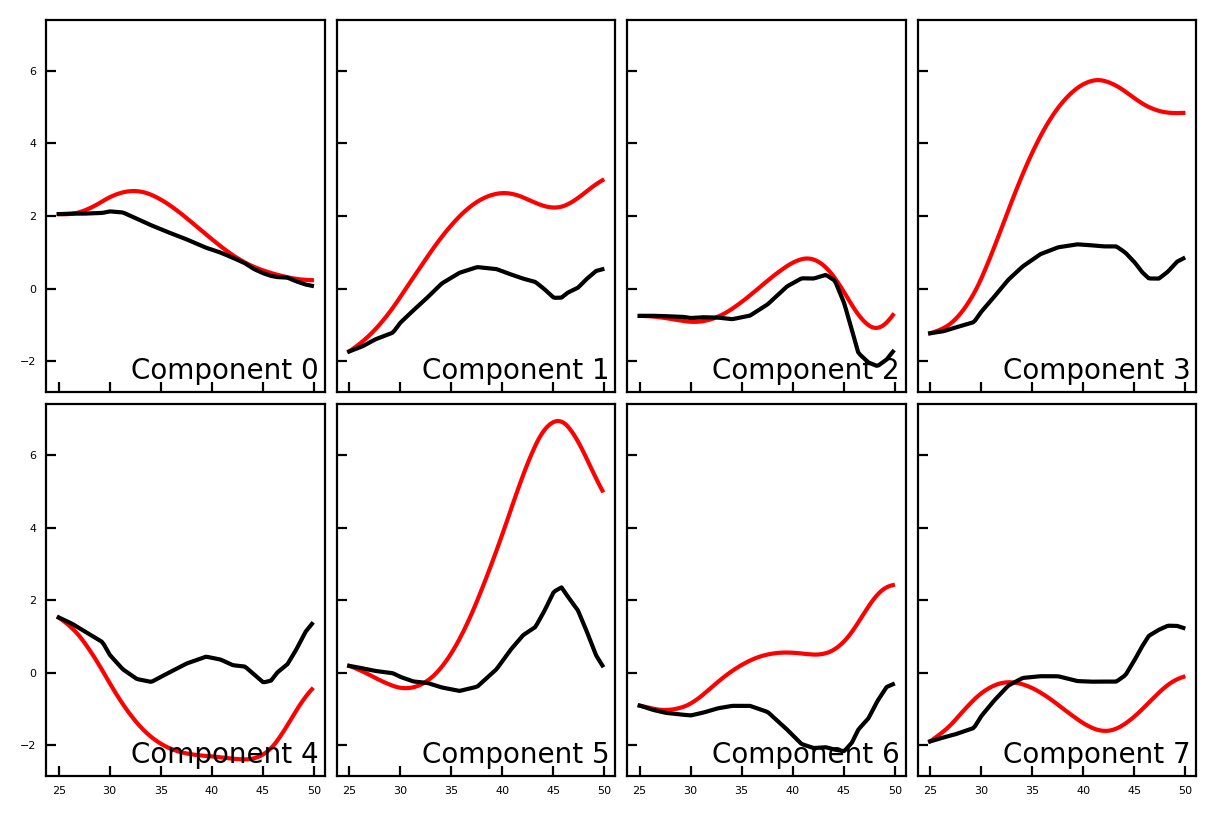

In [444]:
pca_pred = x_model.transform(x_pred.reshape([x_pred.shape[0], -1]))
pca_true = x_model.transform(x_int(times).reshape([pca_pred.shape[0], -1]))

print(pca_pred.shape)

pca_pred = pca_pred[:, keep_x]
pca_true = pca_true[:, keep_x]

ncols = 4
nrows = ceil(pca_pred.shape[1] / ncols)
fig, ax = plt.subplots(nrows, ncols, 
                       sharey=True, sharex=True, dpi=200)
ax = ax.flatten()

for i in range(pca_pred.shape[1]):
    ax[i].plot(times, pca_pred[:, i], color='red')
    ax[i].plot(times, pca_true[:, i], color='black')
    ax[i].text(0.98, 0.02, 'Component %d' % i, fontsize=10, 
               transform=ax[i].transAxes, va='bottom', ha='right')
plt.tight_layout()

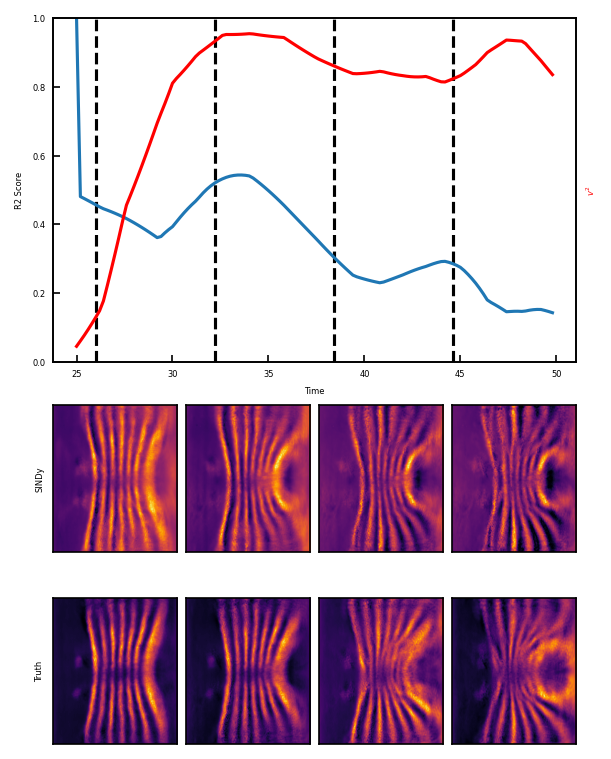

In [445]:
ncols = 4
step = x_pred.shape[0] // ncols

fig = plt.figure(dpi=150, figsize=(1*ncols, 5))
gs = fig.add_gridspec(4, ncols)

plot_fn = color_2D
ax = fig.add_subplot(gs[:2, :])

from sklearn.metrics import r2_score

error = r2_score(
    x_pred.reshape([x_pred.shape[0], -1]).T,
    x_int(times).reshape([x_pred.shape[0], -1]).T,
    multioutput='raw_values'
)

v2 = np.linalg.norm(u_int(times), axis=1).mean(axis=(1, 2))

ax.plot(times, error)
ax.set(ylim=[0, 1],
       ylabel='R2 Score',
       xlabel='Time')
ax2 = ax.twinx()
ax2.plot(times, v2, color='red')
ax2.set_yticks([])
ax2.set_ylabel('$v^2$', color='red')


offset = 5
for i in range(ncols):
    ii = i*step + offset
    color_2D(fig.add_subplot(gs[2, i]), x_pred[ii])
    if i == 0:
        plt.gca().set_ylabel('SINDy')
    color_2D(fig.add_subplot(gs[3, i]), x_int(times[ii]))
    if i == 0:
        plt.gca().set_ylabel('Truth')
    ax.axvline(times[ii], zorder=-1, color='black', linestyle='--')
    
plt.tight_layout()